In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] # 中文輸出(台北黑體)
%matplotlib inline
import pickle

# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 100)

In [2]:
def color_code2cmp(code):
    r = int('0x'+code[1:3], 16)
    g = int('0x'+code[3:5], 16)
    b = int('0x'+code[5:], 16)
    
    vals = np.ones((256, 4))
    vals[:, 0] = np.linspace(1, r/256, 256)
    vals[:, 1] = np.linspace(1, g/256, 256)
    vals[:, 2] = np.linspace(1, b/256, 256)
    return matplotlib.colors.ListedColormap(vals)


def read_vote(file_path):
    cols = ['行政區', '村里', '投票所', '合一行動聯盟', '中華統一促進黨', '親民黨', '安定力量', '台灣基進', '時代力量', '新黨', '喜樂島聯盟', '中國國民黨', '一邊一國行動黨', '勞動黨', '綠黨', '宗教聯盟', '民主進步黨', '台灣民眾黨', '台灣維新', '台澎黨', '國會政黨聯盟', '台灣團結聯盟']
    
    df = pd.read_excel(file_path)
    df = df.iloc[5:, :22]
    df.columns = cols

    dft = df.T

    area = '' # 補上 '村里'的'行政區'
    for i in dft:
        if type(dft[i]['村里']) == float:
            area = dft[i]['行政區'][1:]
        else:
            df['行政區'][i] = area

    df = df[df['村里'].notnull()]
    df['city'] = file_path[-8:-5]

    return df

In [3]:
df_lst = []
for f_p in os.listdir('立委票/'):
    if '不分區' in f_p:
        df_lst.append(read_vote('立委票/' + f_p))

In [4]:
cols = ['city', '行政區', '村里', '投票所', '合一行動聯盟', '中華統一促進黨', '親民黨', '安定力量', '台灣基進', '時代力量', '新黨', '喜樂島聯盟', '中國國民黨', '一邊一國行動黨', '勞動黨', '綠黨', '宗教聯盟', '民主進步黨', '台灣民眾黨', '台灣維新', '台澎黨', '國會政黨聯盟', '台灣團結聯盟']
cols = ['city', '行政區', '村里', '投票所', '親民黨', '台灣基進', '時代力量', '中國國民黨', '民主進步黨', '台灣民眾黨']
data = pd.concat(df_lst).reset_index()[cols]  

In [5]:
cols = ['親民黨', '台灣基進', '時代力量', '中國國民黨', '民主進步黨', '台灣民眾黨']

# 票數是字串 需要移除 ',' 並組合轉成 (int)
for p in cols: 
    data[p] = data[p].str.split(',').str.join('')
# 轉成int
data[cols] = data[cols].astype(float)

# 轉成每一里的比例
# data[cols] = (data[cols].T / data[cols].sum(1) * 100).T

### 兩村里一投票所的問題！

In [6]:
add_df = pd.DataFrame(columns=data.columns).T # 創造一個新df 來存取合併的里

ind = 0
for i in range(data.shape[0]):
    if '、' in data['村里'][i]:
        lst = data['村里'][i].split('、')
        new_lst = list(data.iloc[i].values)
        for area in lst:
            new_lst[2] = area
            add_df[ind] = new_lst
            ind += 1

data = pd.concat([data, add_df.T]) 
data = data[data['村里'].str.find('、') == -1].reset_index()[data.columns]

In [7]:
# 使用 groupby 讓不同投票所同里的可以合併
data = data.drop(columns='投票所')
data['key'] = data.city + data.行政區 + data.村里
data = data.groupby('key').sum()[cols]
# 轉成每一里的比例
data[cols] = (data[cols].T / data[cols].sum(1) * 100).T
data = data.reset_index()

In [8]:
np.all(data.notnull())

True

### 讀取村里圖資料

In [9]:
tw3 = gp.read_file('tw村里圖資/VILLAGE_MOI_1081121.shp')
# 處理不相關資料
tw3 = tw3[['COUNTYNAME', 'TOWNNAME', 'VILLNAME', 'geometry']]
# 處理空值
# tw3 = tw3[np.all(tw3.notnull(), 1)].reset_index()[tw3.columns]
# 做出連結的KEY
tw3['key'] = tw3['COUNTYNAME'] + tw3['TOWNNAME'] + tw3['VILLNAME']

np.all(tw3.notnull())

False

### 發現無法對上的值

```python
s = set(data.key)
for li in list(tw3.key):
    if li not in s:
        print(li)
```

In [10]:
# 補上發現的缺值
tw3.loc[831, 'VILLNAME'] = '𦰡拔里'
tw3.loc[1027, 'VILLNAME'] = '石𥕢里'
tw3.loc[1193, 'VILLNAME'] = '瓊埔村'
tw3.loc[3482, 'VILLNAME'] = '台西村'
tw3.loc[5484, 'VILLNAME'] = '溝垻里'
tw3.loc[6176, 'VILLNAME'] = '石𥕢里'
tw3.loc[7078, 'VILLNAME'] = '濓新里'
tw3.loc[7081, 'VILLNAME'] = '濓洞里'

In [11]:
layout = pd.merge(tw3, data, how='outer')
print(layout.shape)

(7977, 11)


In [12]:
# 重新做出連結的KEY
tw3['key'] = tw3['COUNTYNAME'] + tw3['TOWNNAME'] + tw3['VILLNAME']
# layout = tw3.merge(data)
layout = pd.merge(tw3, data, how='outer') # 作弊因為有缺值

print(data.shape)
print(tw3.shape)
print(layout.shape)

(7764, 7)
(7965, 5)
(7985, 11)


In [13]:
party_name = cols # 政黨
c_lst = ['#ff6213', '#ab3e26', '#ffbf27', '#0008a7', '#009b1c', '#00dbdd'] # 色碼
tw1 = gp.read_file('tw縣市圖資///COUNTY_MOI_1081121.shp')
tw2 = gp.read_file('tw區鄉鎮圖資///TOWN_MOI_1081121.shp')

### 讓圖形顯示更清楚 (極值忽略)  and 補上平均值缺值

In [14]:
data_des = data[cols].describe([0.01, 0.99])

minval = data_des.loc['1%'].values
maxval = data_des.loc['99%'].values

for i, party in enumerate(party_name):
    layout[party] = layout[party].fillna(data[cols].mean().values[i]) # 缺值填入平均值
    layout[party] = np.maximum(np.minimum(layout[party], maxval[i]), minval[i])
    

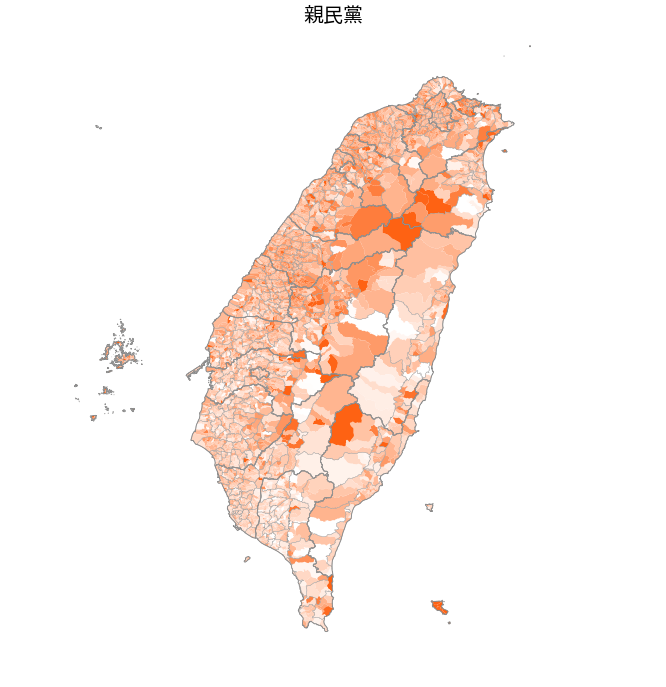

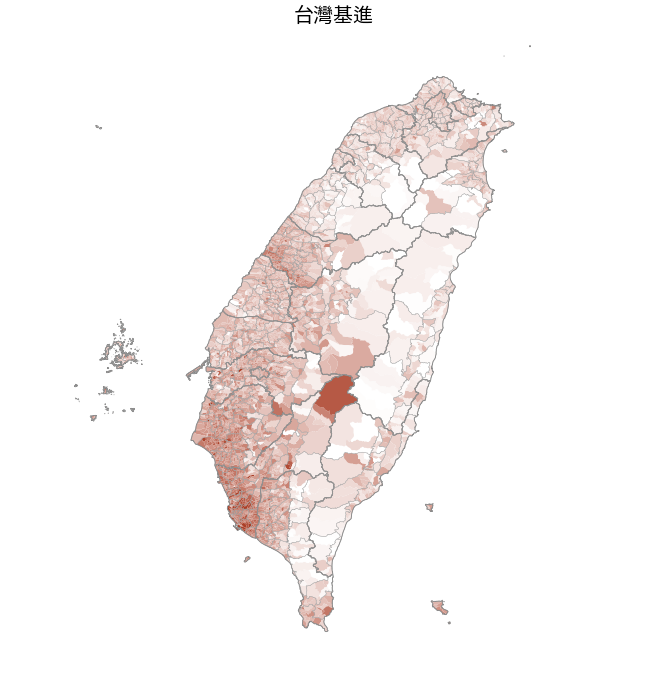

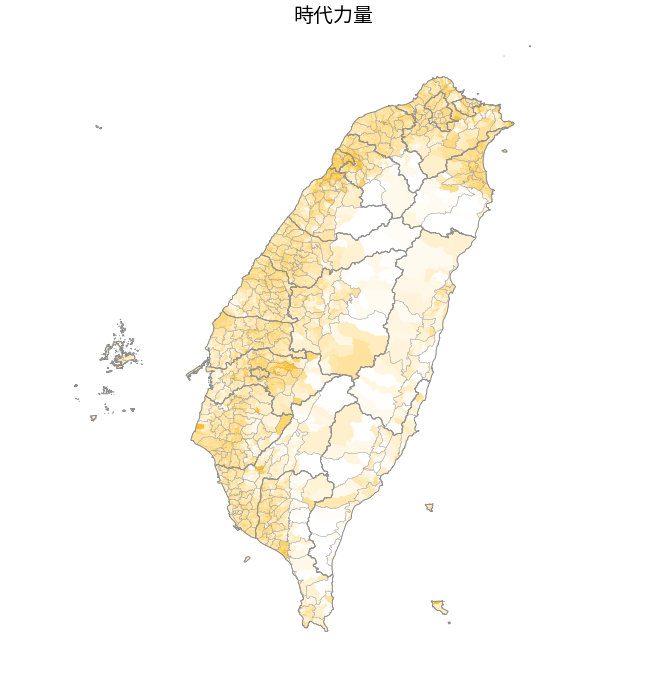

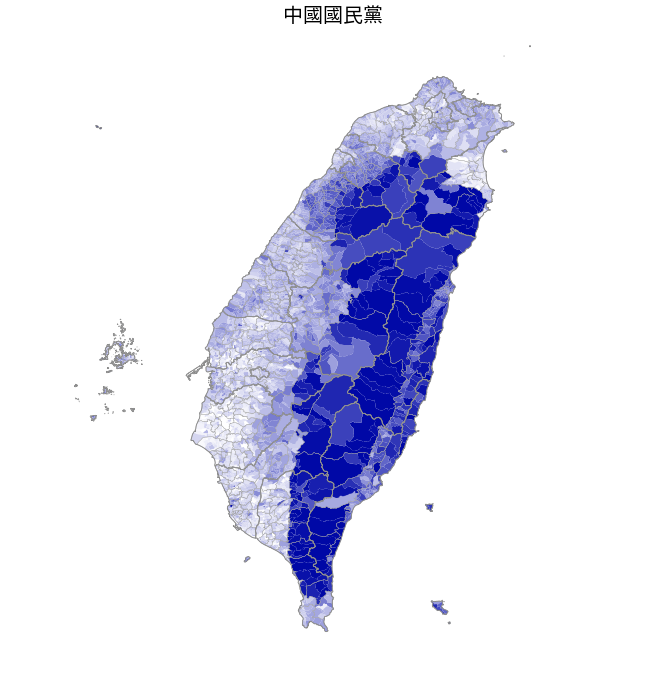

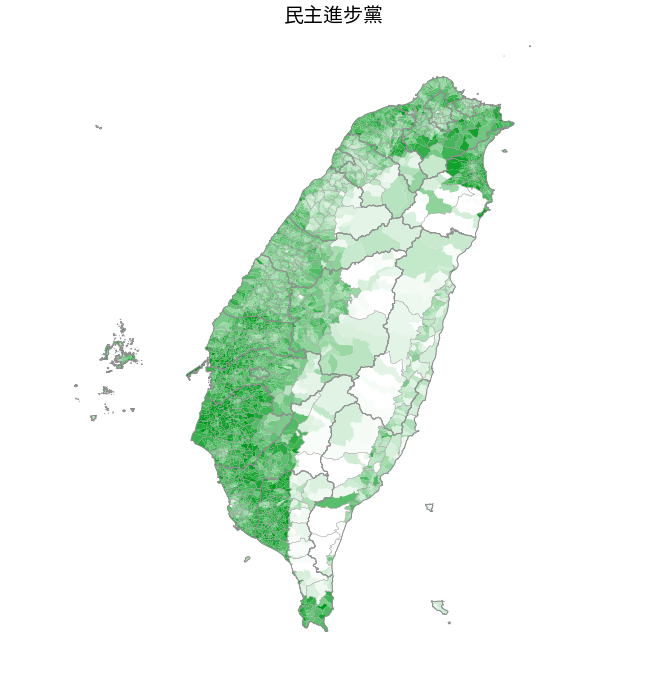

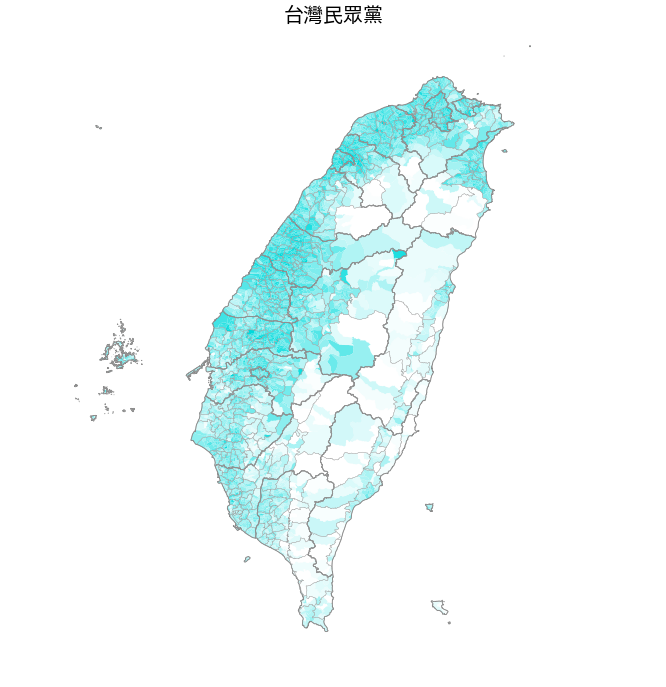

In [15]:
for i in range(6):
    cmp = color_code2cmp(c_lst[i])
    base = layout.plot(figsize=(12, 12), column=cols[i], cmap=cmp)
    tw1.plot(ax=base, fc='', edgecolor='#808080', rasterized=True, lw=0.9)
    tw2.plot(ax=base, fc='', edgecolor='#a0a0a0', rasterized=True, lw=0.3)
    plt.title(party_name[i], fontsize=20)
    
    d = 4
    x = 118.9
    plt.xlim(x, x+d)
    y = 21.6
    plt.ylim(y, y+d)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.box(0)
    plt.show()

In [9]:
data

,key,親民黨,台灣基進,時代力量,中國國民黨,民主進步黨,台灣民眾黨
0,南投縣中寮鄉中寮村,3.836317,1.534527,5.626598,51.662404,30.434783,6.905371
1,南投縣中寮鄉內城村,4.428044,1.107011,4.428044,46.125461,33.579336,10.332103
2,南投縣中寮鄉八仙村,2.801724,1.293103,7.758621,42.887931,37.715517,7.543103
3,南投縣中寮鄉和興村,6.493506,3.376623,6.493506,44.415584,34.025974,5.194805
4,南投縣中寮鄉崁頂村,5.434783,3.985507,4.347826,42.028986,35.507246,8.695652
...,...,...,...,...,...,...,...
7759,高雄市鼓山區鼓岩里,3.061224,5.229592,5.739796,29.081633,52.678571,4.209184
7760,高雄市鼓山區鼓峰里,4.003079,4.541955,6.004619,44.495766,31.023865,9.930716
7761,高雄市鼓山區龍井里,2.048193,7.108434,5.180723,35.783133,45.542169,4.337349
7762,高雄市鼓山區龍子里,3.794115,8.818242,8.524931,34.099726,34.071341,10.691645


In [10]:
data.sort_values('時代力量')

,key,親民黨,台灣基進,時代力量,中國國民黨,民主進步黨,台灣民眾黨
6133,花蓮縣豐濱鄉磯崎村,2.487562,1.492537,0.000000,76.616915,13.930348,5.472637
26,南投縣仁愛鄉榮興村,3.125000,0.000000,0.000000,75.000000,6.250000,15.625000
927,宜蘭縣南澳鄉金洋村,4.593640,1.060071,0.353357,84.098940,6.713781,3.180212
5854,臺東縣延平鄉永康村,1.754386,1.169591,0.584795,88.304094,6.432749,1.754386
925,宜蘭縣南澳鄉碧候村,1.800327,0.327332,0.654664,87.561375,7.692308,1.963993
...,...,...,...,...,...,...,...
3278,新竹市東區龍山里,4.507270,2.956381,20.080775,26.365105,22.229402,23.861066
1325,屏東縣枋寮鄉人和村,2.084831,3.019410,20.704529,31.344357,38.677211,4.169662
3274,新竹市東區關新里,4.942280,2.886003,22.186147,22.582973,22.330447,25.072150
1330,屏東縣枋寮鄉天時村,1.704967,2.520385,24.907339,22.683469,43.291327,4.892513
